# Wireframe Cube 

In [84]:
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from functools import partial
from utils import *

DEBUG = False
CUBE_SIZE = 0.08
IMAGE_FILE_PATH = "../data/images_undistorted/img_0001.jpg"
IMAGE_DISTORTED_FILE_PATH = "../data/images/img_0001.jpg"

POSES_FILE_PATH = "../data/poses.txt"
CALIBRATION_FILE_PATH = "../data/K.txt"
DISTORTION_FILE_PATH = "../data/D.txt"

In [85]:
def get_box_coordinates(origin=np.array([0.0, 0.0, 0.0]), size=1.0):
    coords = np.zeros(shape=(3, 8))
    coords[0, :] = [0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]
    coords[1, :] = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0]
    coords[2, :] = [0.0, 0.0, 0.0, 0.0, -1.0, -1.0, -1.0, -1.0]
    coords = coords * size
    coords[0, :] += origin[0]
    coords[1, :] += origin[1]
    coords[2, :] += origin[2]
    return coords

In [86]:
def draw_cube(coords, ax):
    pair = [(0, 1), (1, 2), (2, 3), (3, 0), 
            (4, 5), (5, 6), (6, 7), (7, 4), 
            (0, 4), (1, 5), (2, 6), (3, 7)]

    for v, w in pair:
        ax.plot([coords[0, v], coords[0, w]], 
                [coords[1, v], coords[1, w]], lw=3, c='r')

In [87]:
def make_homogenous(x):
    N = x.shape[1]
    return np.vstack((x, np.ones(shape=(N,))))

In [88]:
def radial_distortion(p, K, D):
    """
    p: points
    K: calibration matrix
    D: distortion parameters
    """
    u0, v0 = K[0, 2], K[1, 2]
    pd = deepcopy(p)
    r = np.square(pd[0, :] - u0) + np.square(pd[1, :] - v0)
    d = (1 + D[0]*r + D[1]*np.square(r))
    
    pd[0, :] = (p[0, :] - u0) * d + u0
    pd[1, :] = (p[1, :] - v0) * d + v0 
     
    return pd

In [89]:
def project_points(x, K, D=None):
    """
    x: points in the camera frame in homogenous coordinates
    """
    N = x.shape[1]
    
    p = K.dot(x)
    p = p / p[2, :]
    
    if D:
        p_d = radial_distortion(p, K, D)
        return p_d
    else:
        return p

In [90]:
def undistort_image(img, K, D):

    # get x, y (indexes) and z (gray) from image
    # we obey the convention that u is the x coordinate (columns) and y is the y coordinate (rows)
    h, w = img.shape[:2]
    u, v = np.meshgrid(np.arange(0, w), np.arange(0, h))
    
    # get undistorted pixeld coordinates
    pu = np.vstack((u.reshape((1, -1)), 
                    v.reshape((1, -1)))).astype(int)
    
    
    # distort pixel coordinates and approx as ints
    pd = radial_distortion(pu, K, D)
    pd = pd.astype(int)
    
    
    img_undist = np.zeros(shape=(h, w))
    
    # indexing using u as y and v as x (see previous comment)
    img_undist[pu[1, :], pu[0, :]] = img[pd[1, :], pd[0,:]]

    return img_undist

In [91]:
# get checkboard poses from file 
poses = read_poses(POSES_FILE_PATH)

# read intrinsic
K = read_intrinsics(CALIBRATION_FILE_PATH)
print(f"Camera intrinsics:\nK={K}")

# read distortion parameters
D = read_distortion(DISTORTION_FILE_PATH)
print(f"Camera distortion parameters:\nD={D}")

Camera intrinsics:
K=[[420.506712   0.       355.208298]
 [  0.       420.61094  250.336787]
 [  0.         0.         1.      ]]
Camera distortion parameters:
D=[-1.6774e-06, 2.5847e-12]


In [92]:
# generate checkboard corners 
cell_size = 0.04
num_cells = 6
x = np.arange(0, num_cells) * cell_size
y = np.arange(0, num_cells) * cell_size
xv, yv = np.meshgrid(x, y)

# reshape as a matrix N x 3
N = xv.size
points = np.zeros(shape=(3, N))
points[0, :] = xv.reshape(N)
points[1, :] = yv.reshape(N)

In [93]:
# transform checkboard points in camera image
p_check_hom = make_homogenous(points)
p_check_camera_hom = poses[0].dot(p_check_hom)

uv_check = project_points(p_check_camera_hom, K)

# transform cube to image
p_cube_hom = make_homogenous(get_box_coordinates(size=CUBE_SIZE))
p_cube_camera_hom = poses[0].dot(p_cube_hom)

uv_cube = project_points(p_cube_camera_hom, K)

<IPython.core.display.Javascript object>


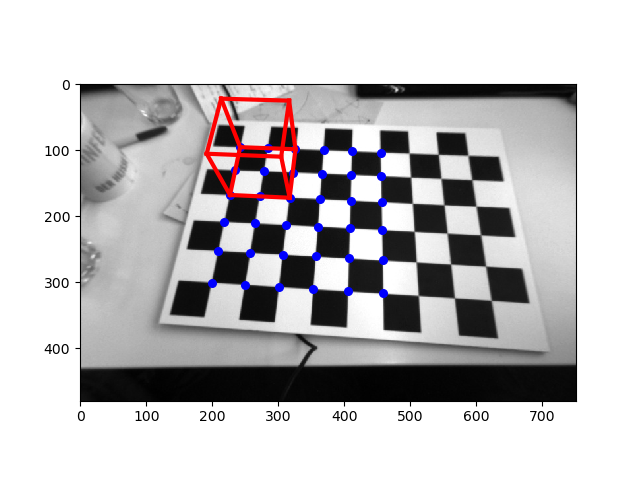

In [94]:
# use flag 0 to read as grayscale image
img_gray = cv2.imread(IMAGE_FILE_PATH, 0)


# plots points and cube on the image
fig, ax = plt.subplots()
ax.imshow(img_gray, cmap='gray')

DEBUG=True
if DEBUG: 
    ax.scatter(uv_check[0, :], uv_check[1, :], 30, c='b')

# Plot cube 
draw_cube(uv_cube, ax)

(480, 752)
[[420.506712   0.       355.208298]
 [  0.       420.61094  250.336787]
 [  0.         0.         1.      ]]


<IPython.core.display.Javascript object>


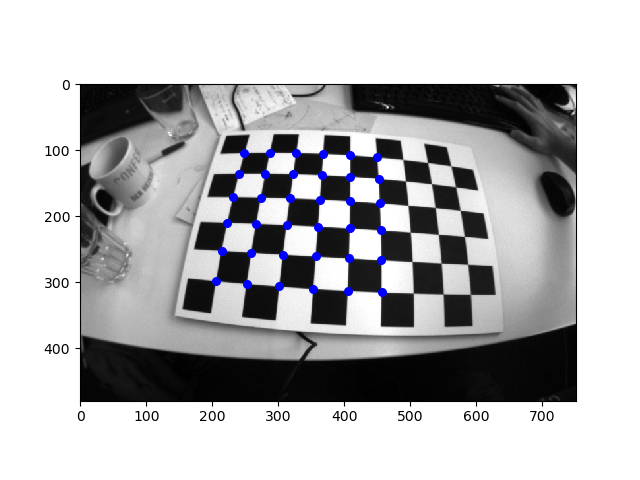

In [95]:
print(img_gray_dist.shape)
print(K)
# Plot on distorted image
img_gray_dist = cv2.imread(IMAGE_DISTORTED_FILE_PATH, 0)

# transform checkboard points in camera image using distortion function
uv_check_dist = project_points(p_check_camera_hom, K, D) 

fig, ax = plt.subplots()
ax.imshow(img_gray_dist, cmap='gray')
ax.scatter(uv_check_dist[0, :], uv_check_dist[1, :], 30, c='b')

<IPython.core.display.Javascript object>


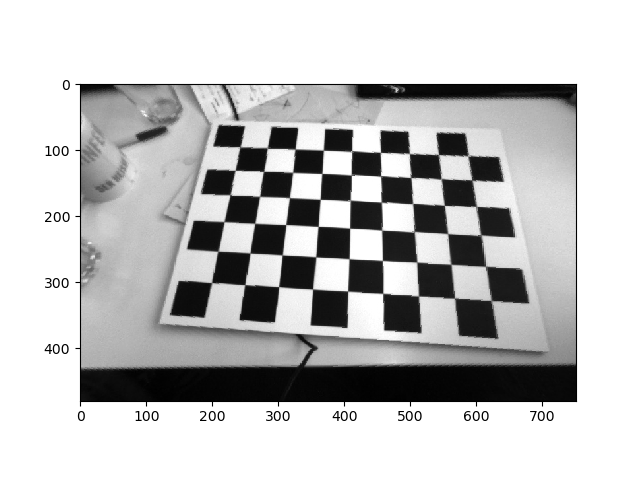

In [96]:
img_gray_udist = undistort_image(img_gray_dist, K, D)
fig, ax = plt.subplots()
ax.imshow(img_gray_udist, cmap='gray')